<h1 align = "center">Sequences, Time Series & Prediction</h1>

**Objective:** In this notebook, a *synthetic* sequence is used to do some statistial forecasting, and later the same sequence will be used in a _machine learning_ model and the performance of the both is compared. A list of utility functions is also built and imported in the notebook, later the same functions are used/modified to serve the needs. The notebook is part of the [DeepLearning.AI Course](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?) from Coursera.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style');

pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 15) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.2f}'.format # float precisions

In [44]:
from scipy.ndimage import uniform_filter1d

In [28]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae
)

In [2]:
from figure import plot
from curves import * # noqa: F403 # pylint: disable=unused-import

## Global Arguments

A set of global arguments to be used by the whole notebook, or can be imported to/from different modules.

In [10]:
times = np.arange(4 * 365 + 1, dtype = np.float32) # 4 years of data

slope = 0.05 # slope of the linear trend data
period = 365 # period of seasonality, the data is repeated yearly

# let also define a `baseline` an initial level value
baseline = 10

# an amplitude is set which is used to control the seasonality
amplitude = 40

In [18]:
# split the data into training and validation based on `split_time`
split_time = 1000

## Synthetic Data

A series of function is used to generate a synthetic data which has a `trend` and `seasonality`. A `noise()` function is also defined which adds _white noise_ into the synthetic data to simulate the behaviour of real world. The seasonality is yearly (i.e., repeats every 365 days) or each 365 steps.

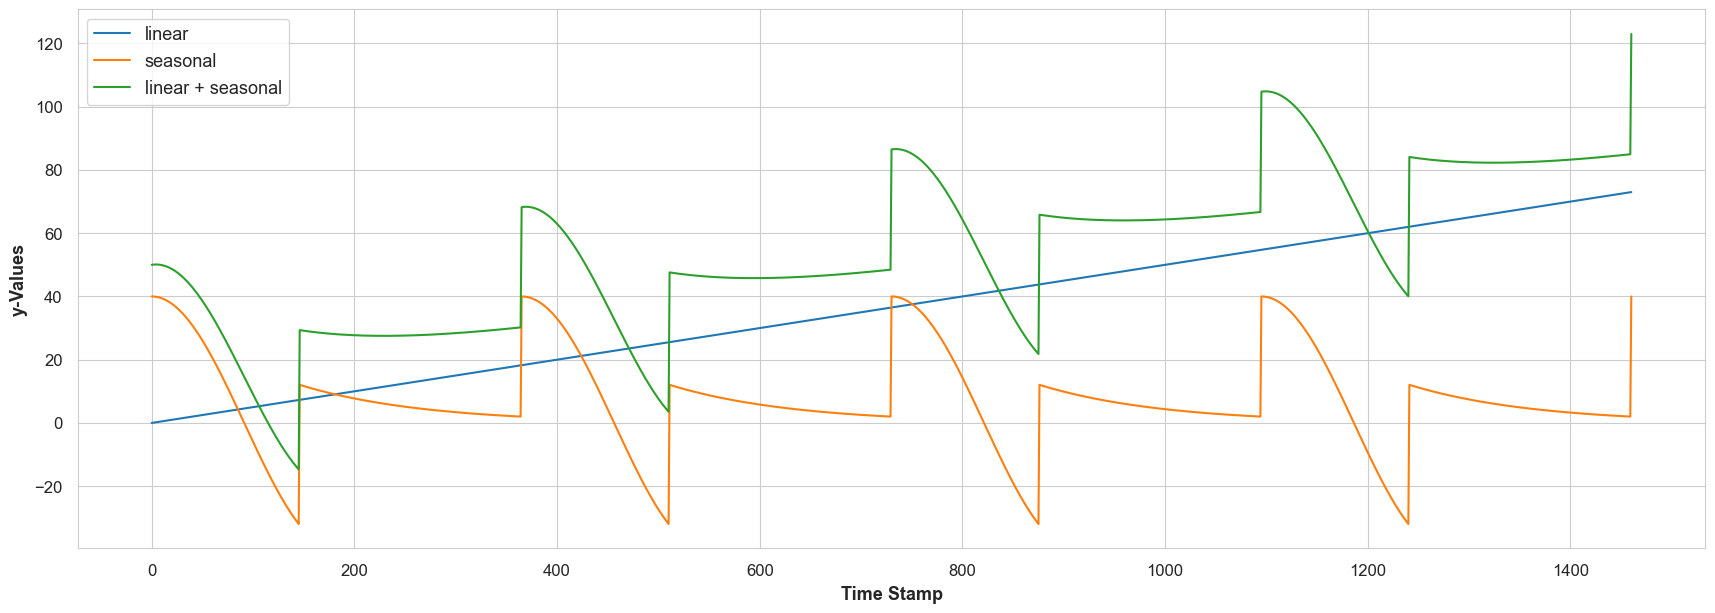

In [15]:
trend_ = trend(times, slope = 0.05)
seasonality_ = seasonality(times, period = period, amplitude = amplitude)

series_ = baseline + trend_ + seasonality_
plot(times, (trend_, seasonality_, series_), label = ["linear", "seasonal", "linear + seasonal"])

In [19]:
time_train = times[:split_time]
time_valid = times[split_time:]

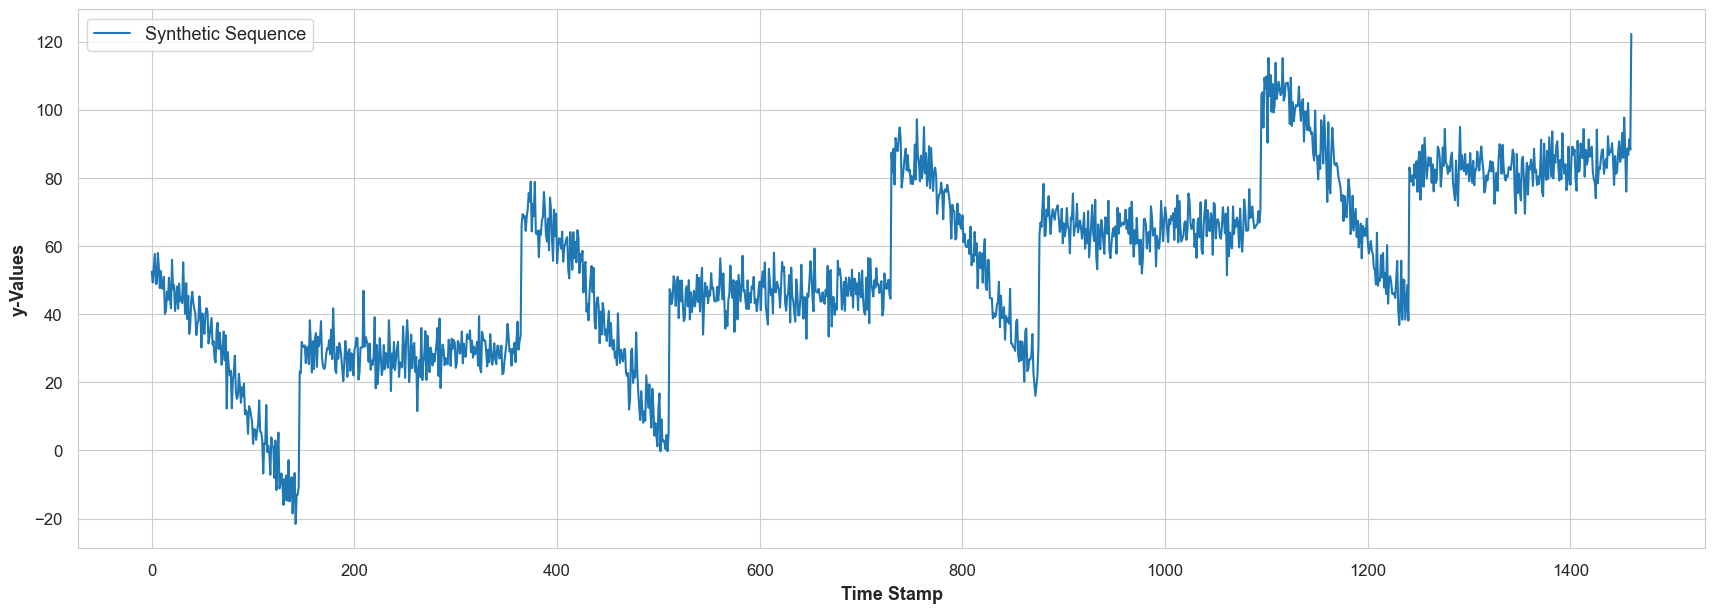

In [22]:
series = series_ + noise(times, level = 5, seed = 42)
plot(times, series, label = "Synthetic Sequence")

In [23]:
# also split the data into `x_train` and `x_valid` from `series`
x_train = series[:split_time]
x_valid = series[split_time:]

## Statistical Models

A set of statistical models are developed and applied.

### Naive Model

A naive forecast (can be treated as baseline) where it is assumed that the next value will be the same as the one in the previous phase.

MSE : 61.83 | MAE : 5.94


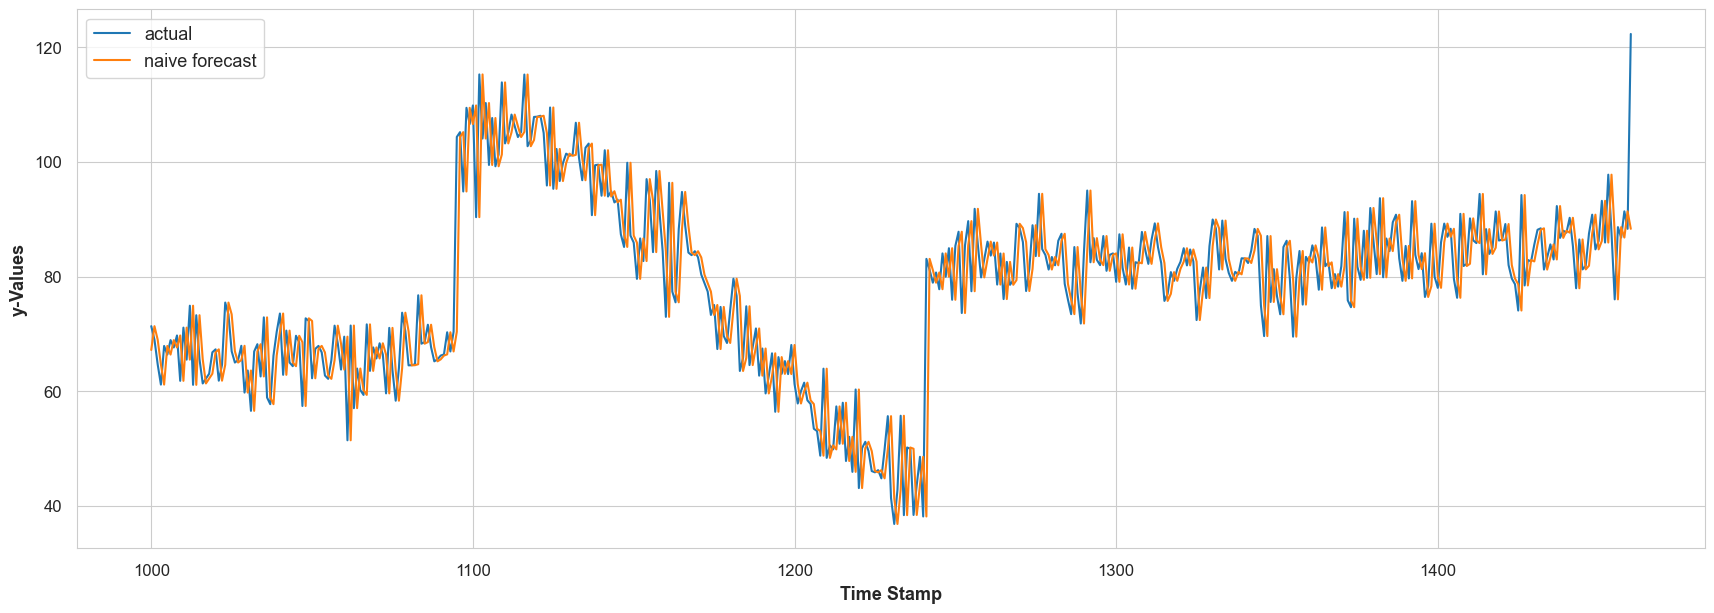

In [36]:
naive_forecast = series[split_time - 1 : -1]

print(f"MSE : {mse(x_valid, naive_forecast):.2f} | MAE : {mae(x_valid, naive_forecast):.2f}")
plot(time_valid, (x_valid, naive_forecast), label = ["actual", "naive forecast"])

### Moving Average Model

`pd.rolling()` :: MSE : 96.99 | MAE : 6.80
`uniform_filter1d()` :: MSE : 40.68 | MAE : 4.76
`uniform_filter1d()` (window = 3) :: MSE : 20.06 | MAE : 3.45


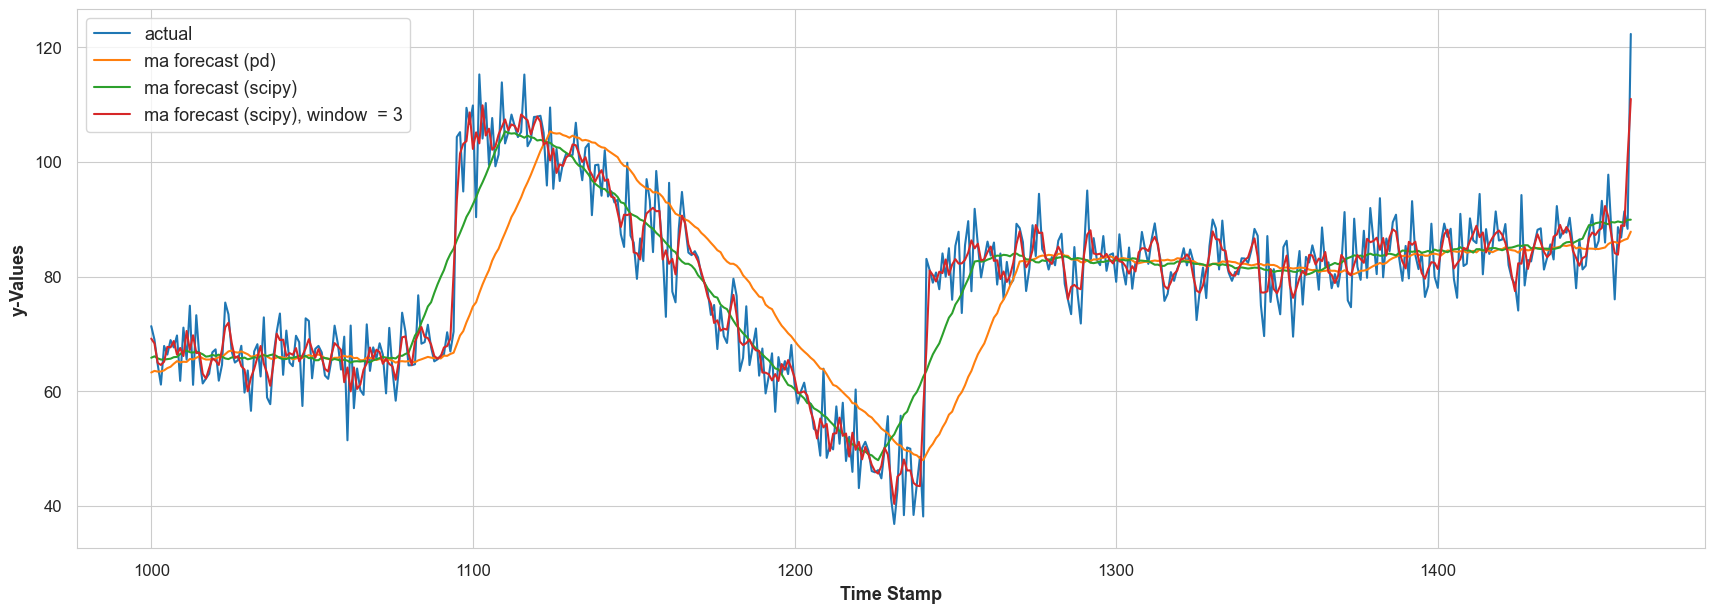

In [51]:
# using the `pd.rolling` method to calculate moving average
# https://stackoverflow.com/a/40060995/6623589
ma_pd_forecast = pd.DataFrame(data = {"times" : times, "sequence" : series})["sequence"].rolling(window = 30).mean().iloc[split_time:].values

# in addition, `scipy` consideres the corner case while determining the rolling
# and can be used directly to calculate the rolling average as provided below
# this gives a far better result than the rolling/ma functions described in the course
# https://stackoverflow.com/a/43200476/6623589
ma_sp_forecast = uniform_filter1d(series, size = 30)[split_time:]

# using a smaller window size reduces the error and gives a more better result,
# but this might overfit the data
ma_sp_forecast_3 = uniform_filter1d(series, size = 3)[split_time:]

print(f"`pd.rolling()` :: MSE : {mse(x_valid, ma_pd_forecast):.2f} | MAE : {mae(x_valid, ma_pd_forecast):.2f}")
print(f"`uniform_filter1d()` :: MSE : {mse(x_valid, ma_sp_forecast):.2f} | MAE : {mae(x_valid, ma_sp_forecast):.2f}")
print(f"`uniform_filter1d()` (window = 3) :: MSE : {mse(x_valid, ma_sp_forecast_3):.2f} | MAE : {mae(x_valid, ma_sp_forecast_3):.2f}")
plot(time_valid, (x_valid, ma_pd_forecast, ma_sp_forecast, ma_sp_forecast_3), label = ["actual", "ma forecast (pd)", "ma forecast (scipy)", "ma forecast (scipy), window  = 3"])